In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import numpy as np 
import matplotlib.pyplot as plt 
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.double)

from botorch.utils.transforms import normalize
from activephasemap.models.gp import MultiTaskGP
from activephasemap.models.np import NeuralProcess
from activephasemap.utils.simulators import UVVisExperiment

import json
pyplot_style ={"text.usetex": True,
               "text.latex.preamble": r"\usepackage{amsfonts}\usepackage[version=4]{mhchem}",
               "axes.spines.right" : False,
               "axes.spines.top" : False,
               "font.size": 12,
               "savefig.dpi": 600,
               "savefig.bbox": 'tight',
              } 

In [14]:
ITERATION = 7
DATA_DIR = "./"
design_space_bounds = [(0.0, 75.0),
                       (0.0, 75.0),
                       (0.0, 75.0),
                       (0.0, 75.0), 
                       (0.0, 11.0),
                       ]

expt = UVVisExperiment(design_space_bounds, ITERATION, DATA_DIR+"/data/")
expt.generate(use_spline=True)
gp_model_args = {"model":"gp", "num_epochs" : 1, "learning_rate" : 1e-5, "verbose": 1}
np_model_args = {"num_iterations": 1, "verbose":True, "print_freq":100, "lr":5e-4}
input_dim = expt.dim

with open('../best_config.json') as f:
    best_np_config = json.load(f)
N_LATENT = best_np_config["z_dim"]

# Load trained GP model for p(z|c)
train_x = torch.load(DATA_DIR+'/output/train_x_%d.pt'%ITERATION, map_location=device)
train_y = torch.load(DATA_DIR+'/output/train_y_%d.pt'%ITERATION, map_location=device)
train_y_std = 0.1*torch.ones_like(train_y)
bounds = expt.bounds.to(device)
normalized_x = normalize(train_x, bounds).to(train_x)
gp_model = MultiTaskGP(normalized_x, train_y, gp_model_args, expt.dim, N_LATENT, train_y_std)
gp_state_dict = torch.load(DATA_DIR+'/output/gp_model_%d.pt'%(ITERATION), map_location=device)
gp_model.load_state_dict(gp_state_dict)

# Load trained NP model for p(y|z)
np_model = NeuralProcess(best_np_config["r_dim"], N_LATENT, best_np_config["h_dim"]).to(device)
np_model.load_state_dict(torch.load(DATA_DIR+'/output/np_model_%d.pt'%(ITERATION), map_location=device))

Loading data from iteration 0 with shapes: (72, 5) (72, 101)
Loading data from iteration 1 with shapes: (87, 5) (87, 101)
Loading data from iteration 2 with shapes: (86, 5) (86, 101)
Loading data from iteration 3 with shapes: (84, 5) (84, 101)
Loading data from iteration 4 with shapes: (87, 5) (87, 101)
Loading data from iteration 5 with shapes: (87, 5) (87, 101)
Loading data from iteration 6 with shapes: (87, 5) (87, 101)


<All keys matched successfully>

### Plot predictions of the model at trained compositions 
We randomly sample few training points and plot the model prediction to compare with the actual spectra

In [15]:
import matplotlib.ticker as ticker

def prettify_spectra_plot(ax, wl, spectra):
    ax.set_xlim([wl.min(), wl.max()])
    ax.set_ylim([spectra.min(), spectra.max()+0.2])
    ax.xaxis.set_major_locator(ticker.MaxNLocator(3))
    ax.yaxis.set_major_locator(ticker.LinearLocator(5))
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f}"))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    return ax

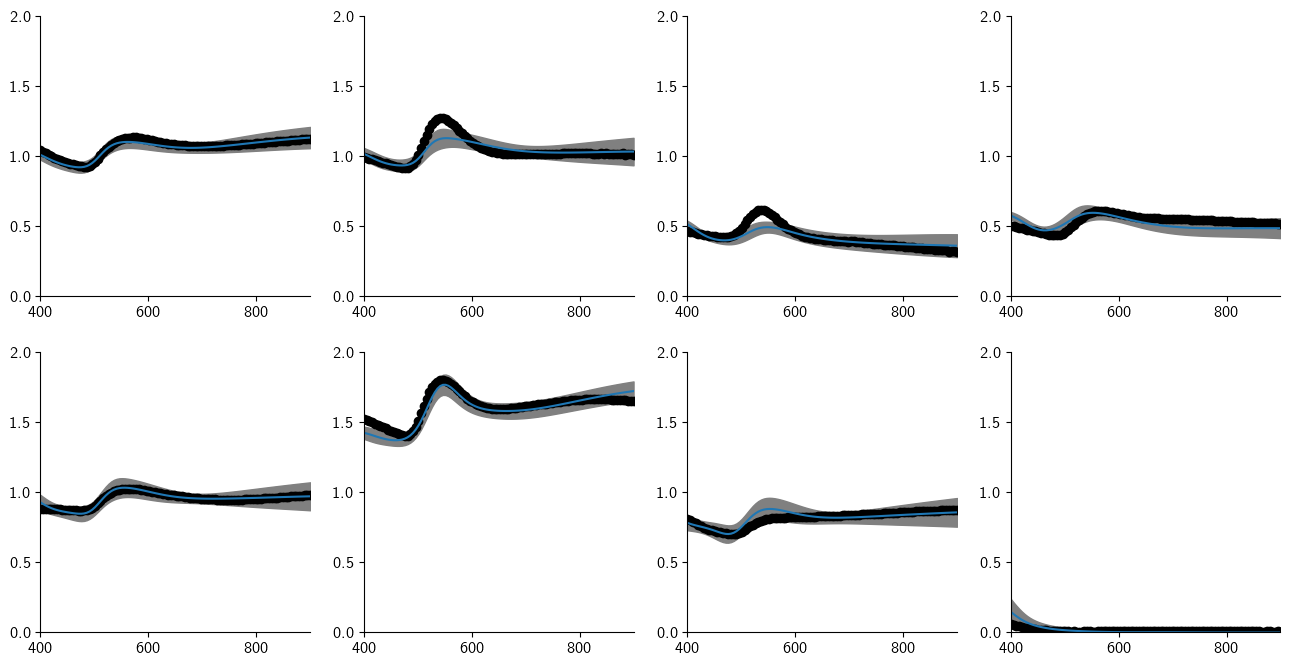

In [21]:
from activephasemap.utils.visuals import plot_gpmodel_recon

with plt.style.context(pyplot_style):
    fig, axs = plt.subplots(2,4, figsize=(4*4, 4*2))
    axs = axs.flatten() 
    rids = np.random.randint(0, expt.comps.shape[0], size=8)
    plot_comps = expt.comps[rids,:]
    plot_spectra = expt.spectra_normalized[rids,:]
    for i, ax in enumerate(axs):
        ci = plot_comps[i,:].reshape(1, -1)
        plot_gpmodel_recon(ax, gp_model, np_model, expt, ci)
        ax.scatter(expt.wl, plot_spectra[i,:], color='k')
        # ax.set_title("ID %d"%rids[i])
        prettify_spectra_plot(ax, expt.wl, plot_spectra)
    plt.show()

### Plot predictions of the model at compositions it is currently requesting
We first predict the spectra at locations the model has requested to sample (because it has not seen spectra at those locations and thus are informative) and compare them with the actual sampled curve.

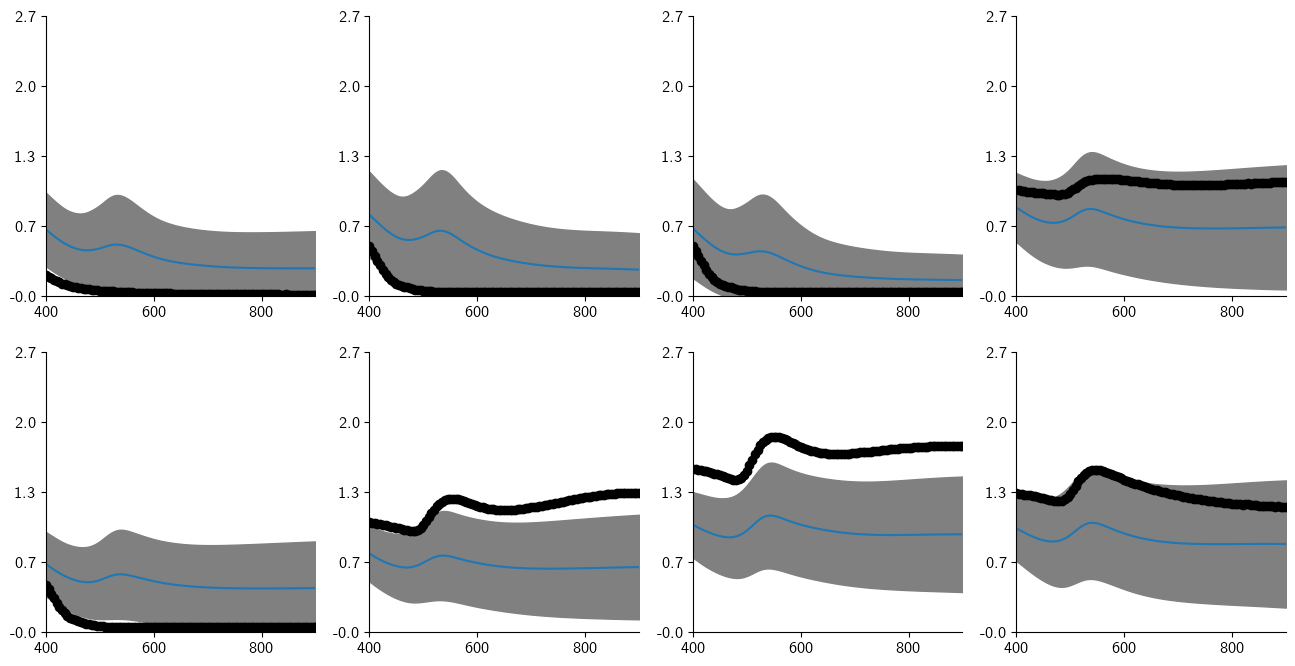

In [22]:
with plt.style.context(pyplot_style):
    fig, axs = plt.subplots(2,4, figsize=(4*4, 4*2))
    axs = axs.flatten()
    next_comps = np.load(DATA_DIR+"/data/comps_%d.npy"%(ITERATION))
    next_spectra = np.load(DATA_DIR+"/data/spectra_%d.npy"%(ITERATION))
    wav = np.load(DATA_DIR+"/data/wav.npy")
    rids = np.random.randint(0, next_comps.shape[0], size=8)
    for i, ax in enumerate(axs):
        ci = next_comps[rids[i],:].reshape(1, -1)
        si = next_spectra[rids[i],:]
        plot_gpmodel_recon(ax, gp_model, np_model, expt, ci)
        ax.scatter(wav, si, color='k')
        prettify_spectra_plot(ax, expt.wl, next_spectra)
    plt.show()